In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Load the CSV files
train_data_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\19X400X150_patch90_coordinates\landmark_13_coordinates.csv')

# Combine the dataframes
df = train_data_df
# Adjust the splitting ratios
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Split the dataframe into train, test, and validation sets
train_df, test_val_df = train_test_split(df, test_size=(test_ratio + val_ratio), random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=val_ratio/(test_ratio + val_ratio), random_state=42)

# Print the number of data points in each set
print("Number of data points in train set:", len(train_df))
print("Number of data points in validation set:", len(val_df))
print("Number of data points in test set:", len(test_df))

# Data augmentation configuration
# Data augmentation configuration
data_gen_args = {
    'rescale': 0.004,  # Rescale with a factor of 0.004
    'horizontal_flip': True,  # Horizontal flipping
    'vertical_flip': False,  # Vertical flipping is not included
    'zoom_range': 0.2,  # Zooming in and out by a factor of 2
    'shear_range': 2.0,  # Random shearing with a factor of 2
    'rotation_range': 0,  # Rotation is not included
    'fill_mode': 'nearest'
}


# ImageDataGenerator for training
train_datagen = ImageDataGenerator(**data_gen_args)

# ImageDataGenerator for testing/validation
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch90\landmark_13',
    x_col='patch_filename',
    y_col=['x', 'y'],
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=True
)

# Generator for validation data
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch90\landmark_13',
    x_col='patch_filename',
    y_col=['x', 'y'],
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Generator for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch90\landmark_13',
    x_col='patch_filename',
    y_col=['x', 'y'],
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Save test data to CSV
test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\test_CephaNet_L13.csv', index=False)


Number of data points in train set: 41999
Number of data points in validation set: 6001
Number of data points in test set: 12000
Found 41999 validated image filenames.
Found 6001 validated image filenames.
Found 12000 validated image filenames.


In [2]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Reshape, Multiply, Add, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Adjust dropout rate
dropout_rate = 0.3

# Define the Squeeze-and-Excitation Block
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    x = Multiply()([init, se])
    return x

# Define the CNM Layer
def cnm_layer(input_tensor, filters, kernel_size=(3,3), pool_size=(2,2)):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size)(x)
    return x

# Input layer
input_layer = Input(shape=(64, 64, 1))  # You may need to adjust the input shape

# First CNM Layer
cnml1 = cnm_layer(input_layer, 32)
cnml1 = cnm_layer(cnml1, 64)

# Squeeze-and-Excitation Block
seb = squeeze_excite_block(cnml1)

# Skip Connection with element-wise summation
skip_connection = Add()([cnml1, seb])

# Second CNM Layer with skip connection as input
cnml2 = cnm_layer(skip_connection, 128)
cnml2 = cnm_layer(cnml2, 256)

# Flatten and Dense layers for regression
flatten = Flatten()(cnml2)
dropout = Dropout(dropout_rate)(flatten)  # Adjusted dropout rate
dense = Dense(512, activation='relu')(dropout)
dropout = Dropout(dropout_rate)(dense)  # Adjusted dropout rate
dense = Dense(256, activation='relu')(dropout)

# Output layer for regression
output_regression = Dense(2, activation='relu')(dense)  # Assuming 19 landmarks to predict

# Create the model
model = Model(inputs=input_layer, outputs=output_regression)

# Define optimizer without the decay argument
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)  

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using mean squared error for regression

# Model Summary
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        260 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 64)  │        320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 8, 8, 256) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,617,926 (9.99 MB)

 Trainable params: 2,617,926 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 433s 324ms/step - loss: 156.9769 - val_loss: 66.8866
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 118s 90ms/step - loss: 67.7361 - val_loss: 52.0360
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 121s 92ms/step - loss: 56.6919 - val_loss: 50.0653
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 121s 91ms/step - loss: 51.2129 - val_loss: 42.6974
Epoch 5/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 121s 92ms/step - loss: 46.3131 - val_loss: 39.6120
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 120s 91ms/step - loss: 41.9433 - val_loss: 33.8385
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 121s 92ms/step - loss: 38.9310 - val_loss: 30.3761
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 121s 92ms/step - loss: 34.3610 - val_loss: 28.1465
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 122s 92ms/step - loss: 31.7549 - val_loss: 25.3586
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 121s 92ms/step - loss: 29.6885 - val_loss: 22.1906
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 121s 92ms/step - loss: 28

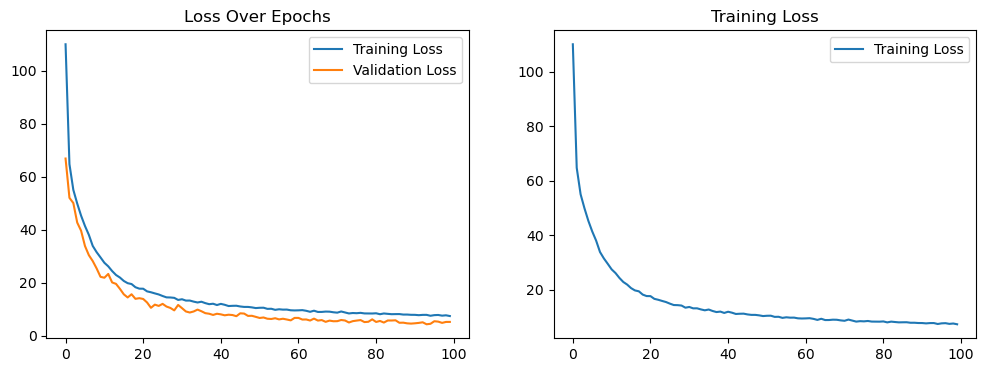

In [3]:
import time
import matplotlib.pyplot as plt

# Start training
start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1  # Added verbose argument to provide training progress
)

# End time
end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f} seconds")

# Plot the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

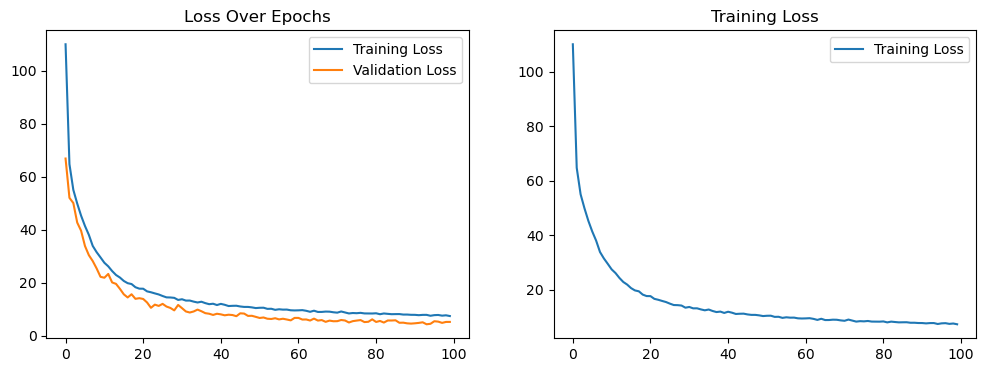

In [4]:
import matplotlib.pyplot as plt

# Your code to plot the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.legend()

# Save the graph as JPG
plt.savefig(r'C:\Users\Student\Desktop\Shalu\All Graphs\CephaNet_l13', dpi=300)  # Specify the file name and dpi (dots per inch)
plt.show()


In [5]:

# Save the trained model to a specific directory
model.save(r'C:\Users\Student\Desktop\Shalu\CephaNet__L13.h5')


In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\test_CephaNet_L13.csv',)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch90\landmark_13',
    x_col='patch_filename',
    y_col=['x', 'y'],  # Ensure column names match your actual data
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions

# Save the dataframe with true and predicted coordinates to CSV
#test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\cephaXnet_predictions_My_L1.csv', index=False)
#print("Predictions saved to CSV file.")


Found 12000 validated image filenames.
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:28 236ms/step

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step


In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = test_df

# Calculate relative errors (REi) for each landmark in millimeters
predictions_df['REi'] = (np.sqrt((predictions_df['predicted_x'] - predictions_df['x'])**2 + 
                                  (predictions_df['predicted_y'] - predictions_df['y'])**2)) * 0.1

# Calculate Mean Relative Error (MRE) and Standard Deviation (SD) of REi
MRE = predictions_df['REi'].mean()
SD = predictions_df['REi'].std()


# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['predicted_x'])**2 + (predictions_df['y'] - predictions_df['predicted_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)
# Display MRE, SD, and SDR values
print("Mean Relative Error (MRE):", MRE)
print("Standard Deviation (SD) of Relative Errors (REi):", SD)


# Save predictions with REi to a CSV file if needed
# predictions_df.to_csv('predictions_with_REi.csv', index=False)
# print("Predictions with REi saved to CSV file.")

# Save SDR values to a CSV file if needed
# sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
# sdr_df.to_csv('sdr_values.csv', index=False)
# print("SDR values saved to CSV file.")

SDR within precision ranges: {'2.0mm': '99.97%', '2.5mm': '99.97%', '3.0mm': '99.98%', '4.0mm': '100.00%'}
Mean Relative Error (MRE): 0.23687470461437227
Standard Deviation (SD) of Relative Errors (REi): 0.14653426073065648


## Test1

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\19X400X150_test1patch90_coordinates\landmark_13_coordinates.csv',)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_test1patch90\landmark_13',
    x_col='patch_filename',
    y_col=['x', 'y'],  # Ensure column names match your actual data
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions

# Save the dataframe with true and predicted coordinates to CSV
#test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\cephaXnet_predictions_My_L1.csv', index=False)
#print("Predictions saved to CSV file.")


Found 60000 validated image filenames.
   1/1875 ━━━━━━━━━━━━━━━━━━━━ 2:33 82ms/step

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 270s 144ms/step


In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = test_df

# Calculate relative errors (REi) for each landmark in millimeters
predictions_df['REi'] = (np.sqrt((predictions_df['predicted_x'] - predictions_df['x'])**2 + 
                                  (predictions_df['predicted_y'] - predictions_df['y'])**2)) * 0.1

# Calculate Mean Relative Error (MRE) and Standard Deviation (SD) of REi
MRE = predictions_df['REi'].mean()
SD = predictions_df['REi'].std()


# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['predicted_x'])**2 + (predictions_df['y'] - predictions_df['predicted_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)
# Display MRE, SD, and SDR values
print("Mean Relative Error (MRE):", MRE)
print("Standard Deviation (SD) of Relative Errors (REi):", SD)


# Save predictions with REi to a CSV file if needed
# predictions_df.to_csv('predictions_with_REi.csv', index=False)
# print("Predictions with REi saved to CSV file.")

# Save SDR values to a CSV file if needed
# sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
# sdr_df.to_csv('sdr_values.csv', index=False)
# print("SDR values saved to CSV file.")

SDR within precision ranges: {'2.0mm': '93.62%', '2.5mm': '98.14%', '3.0mm': '99.65%', '4.0mm': '100.00%'}
Mean Relative Error (MRE): 0.9391928242942815
Standard Deviation (SD) of Relative Errors (REi): 0.5930354621753684


## Test2

In [10]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\19X400X150_test2patch90_coordinates\landmark_13_coordinates.csv',)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_test2patch90\landmark_13',
    x_col='patch_filename',
    y_col=['x', 'y'],  # Ensure column names match your actual data
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions

# Save the dataframe with true and predicted coordinates to CSV
#test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\cephaXnet_predictions_My_L1.csv', index=False)
#print("Predictions saved to CSV file.")


Found 40000 validated image filenames.
   1/1250 ━━━━━━━━━━━━━━━━━━━━ 1:50 88ms/step

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 180s 144ms/step


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = test_df

# Calculate relative errors (REi) for each landmark in millimeters
predictions_df['REi'] = (np.sqrt((predictions_df['predicted_x'] - predictions_df['x'])**2 + 
                                  (predictions_df['predicted_y'] - predictions_df['y'])**2)) * 0.1

# Calculate Mean Relative Error (MRE) and Standard Deviation (SD) of REi
MRE = predictions_df['REi'].mean()
SD = predictions_df['REi'].std()


# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['predicted_x'])**2 + (predictions_df['y'] - predictions_df['predicted_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)
# Display MRE, SD, and SDR values
print("Mean Relative Error (MRE):", MRE)
print("Standard Deviation (SD) of Relative Errors (REi):", SD)


# Save predictions with REi to a CSV file if needed
# predictions_df.to_csv('predictions_with_REi.csv', index=False)
# print("Predictions with REi saved to CSV file.")

# Save SDR values to a CSV file if needed
# sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
# sdr_df.to_csv('sdr_values.csv', index=False)
# print("SDR values saved to CSV file.")

SDR within precision ranges: {'2.0mm': '59.99%', '2.5mm': '76.43%', '3.0mm': '88.80%', '4.0mm': '99.22%'}
Mean Relative Error (MRE): 1.7591494150387923
Standard Deviation (SD) of Relative Errors (REi): 0.9498170423928501


## Image Registration Test1

In [12]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\Test1_Coordinate\L_13.csv')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\All_ROIs_test1',
    x_col='patch_filename',
    y_col=['reference_x', 'reference_y','test_original_x','test_original_x'],  # Ensure column names match your actual data
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions
# Add two additional columns x and y with adjusted values
test_df['x'] = test_df['reference_x'] - 45 + test_df['predicted_x']
test_df['y'] = test_df['reference_y'] - 45 + test_df['predicted_y']

# Save the dataframe with true and predicted coordinates to CSV
#test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\test1_L2.csv', index=False)
#print("Predictions saved to CSV file.")

Found 150 validated image filenames.
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = test_df

# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['test_original_x'])**2 + (predictions_df['y'] - predictions_df['test_original_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)

# Save SDR values to a CSV file
#sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
#sdr_df.to_csv('/content/drive/MyDrive/ISBI_Dataset/sdr_values1.csv', index=False)
#print("SDR values saved to CSV file.")


SDR within precision ranges: {'2.0mm': '23.33%', '2.5mm': '26.00%', '3.0mm': '30.00%', '4.0mm': '36.00%'}
